# Faraday Dreams Example

Below you can find a tutorial that shows simulation of measurements from a ground truth Faraday depth signal. Then recovery is performed using Optimus Primal. 

This tutorial shows basic recovery of a Faraday depth signal for an observation

In [8]:
import sys
sys.path.insert(0,'..')
#put path to optimusprimal git repo
sys.path.insert(0,'../../Optimus-Primal')
import optimusprimal.prox_operators as prox_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.primal_dual as primal_dual
import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.models as models
import faradaydreams.convex_solvers as solvers
import faradaydreams.utilities as utilities
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '16'

This next bit of code sets up the parameters for the observation. The samples in frequency $\nu$, which determine the samples in $\lambda^2$. 

In [9]:
c = 299792458 #speed of light m/s
m_size = 128 #numbr of channels
ISNR = 1. #signal to noise ratio of input noise
freq0 =  np.linspace(1.3e3, 9.7e3, m_size) * 10**6 # frequency coverage
dfreq = np.abs(freq0[1] - freq0[0]) # channel width
lambda2, dlambda2 = utilities.calculate_lambda2(freq=freq0, dfreq=dfreq)
phi_max, phi_min, dphi = measurement_operator.phi_parameters(lambda2, dlambda2) #sensitivity estiamtes given coverage
dphi = 15
print(dphi)
Nd = 320
phi = measurement_operator.create_phi_array(Nd, dphi)
print(np.max(phi))
weights = np.ones(m_size) #choosing flat noise
rm_max = 100#np.min([500, phi_max]) #only for plotting

2021-10-12 18:52:17,133 - Faraday Dreams - INFO - φ resolution 29.536917895865994 rad/m^2.
2021-10-12 18:52:17,134 - Faraday Dreams - INFO - φ max range is 76764.095988163 rad/m^2.
2021-10-12 18:52:17,134 - Faraday Dreams - INFO - φ min range is 184.55286928554156 rad/m^2.
15
2385.0


### Constructing the model
Below we construct a ground truth Faraday Depth, this can be delta functions, box functions, or gaussian functions.

In [10]:
x_true = np.zeros(phi.shape, dtype=complex) * 0j #zero model of signal

We can assume the structure for Stokes I is determined by single electron population Synchrotron spectrum with $\alpha = \frac{\delta - 1}{2}$ with $\nu^{-\alpha}$
\begin{equation}
    I(\nu) = (\nu/\nu_1)^{5/2}\left [ 1 - {\rm e}^{-(\nu/\nu_1)^{(\delta + 4)/2}} \right] I_0\, .
\end{equation}
This structure has a power law with a slope of 5/2 for $\nu$ much less than $\nu_1$ and has a power law with spectra index $\alpha = (1 - \delta)/2$ when $\nu$ is much greater than $\nu_1$. Note that his model assumes a single electron population. We can perform a change of variables to $\lambda^2$ to get the equivalent equation
\begin{equation}
    I(\lambda^2) = (\lambda^2/\lambda^2_1)^{-5/4}\left [ 1 - {\rm e}^{-(\lambda^2/\lambda^2_1)^{-(\delta + 4)/4}} \right] I_0\, .
\end{equation}
At small wavelengths squared we have a power law with slope $\beta = -(1 - \delta)/4$ and at large wavelengths squared we have a power law with slope $-5/4$.

In [11]:
alpha = -0.8
delta = (-2 * alpha + 1)
nus = [5000, 2000, 800, 2000]
rms = [0, 0, 0, 100]
spectra2 = lambda x: np.real((x/lambda2_0)**(-5/4) * (1 - np.exp(-(x/lambda2_0)**((delta + 4)/2))))
spectra3 = lambda x: np.sin(2 * np.pi/2. * x)
#choose basis for enforce sparisty
wav = ["dirac"]
levels = 1 #wavelet levels, makes no difference for dirac

### Constructing the measurement matrix
The measurement process can be written in the measurement equation
$$P(\lambda^2) = \int P(\phi) {\rm e}^{2 i \lambda^2 \phi}\Delta \phi \, ,$$
which maps Faraday Depth $\phi$ to the measured wavelength $\lambda^2$ for $P = Q +iU$.
The measurement matrix is determined by the following sum: 
$$P(\lambda^2_p) = \sum_{k=0}^N P(\phi_k){\rm e}^{2 i \lambda^2_p \phi_k}\Delta \phi_k$$
where $P$ is the complex polarization signal. It is a Fourier series between $\lambda^2$ and $\phi$.

We can write this as $$\mathbf{y} = \mathbf{\mathsf{\Phi}}\mathbf{x}$$ since it is a system of linear equations.

In [12]:
# measurement operator
m_op =  measurement_operator.faraday_operator(lambda2, phi, weights)

Below we also create a version for comparing a noise free and better sampling instrument

In [13]:
# measurement operator without channel averaging
lambda2_high_res = measurement_operator.create_lambda2_array(Nd, dphi)
m_op_high_res = measurement_operator.faraday_operator(lambda2_high_res, phi, lambda2_high_res * 0 + 1)

We calculate our simulated measurements $y$ with added noise.

2021-10-12 18:52:19,154 - Optimus Primal - INFO - Starting Power method
2021-10-12 18:52:19,155 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-10-12 18:52:19,159 - Optimus Primal - INFO - [Power Method] Converged with norm= 9097.319487131064, iter = 11, tol = 9.276575044261321e-05
2021-10-12 18:52:19,160 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 1 levels
2021-10-12 18:52:19,160 - Faraday Dreams - INFO - Using an estimated noise level of 71.4717026751986 (Jy)
2021-10-12 18:52:19,162 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2021-10-12 18:52:19,163 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-10-12 18:52:19,165 - Optimus Primal - INFO - [Primal Dual] 0 out of 50000 iterations, tol = 0.000000
2021-10-12 18:52:19,867 - Optimus Primal - INFO - [Primal Dual] 1000 out of 50000 iterations, tol = 0.002760
2021-10-12 18:52:20,565 - Optimus Primal - INFO - [Primal Dual] 2000 out of 50000 itera

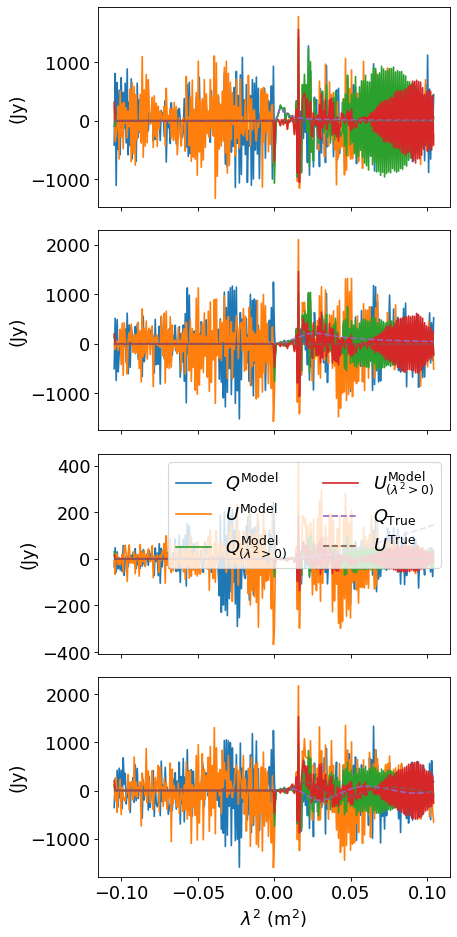

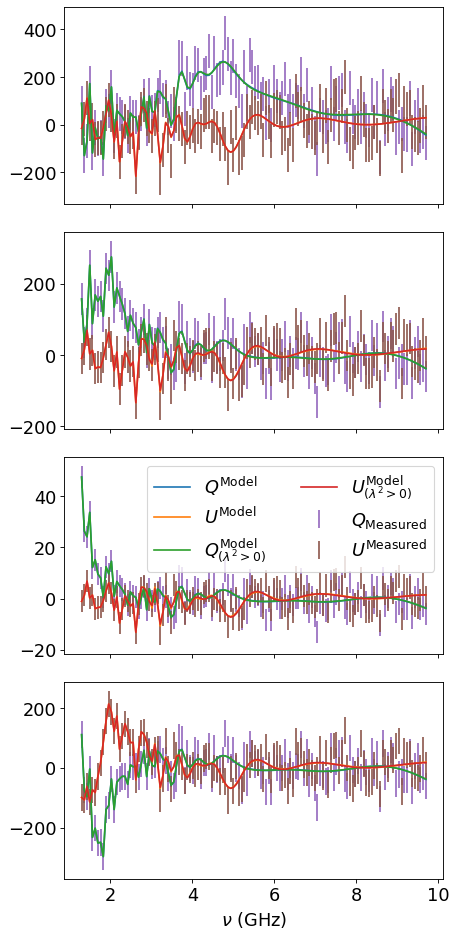

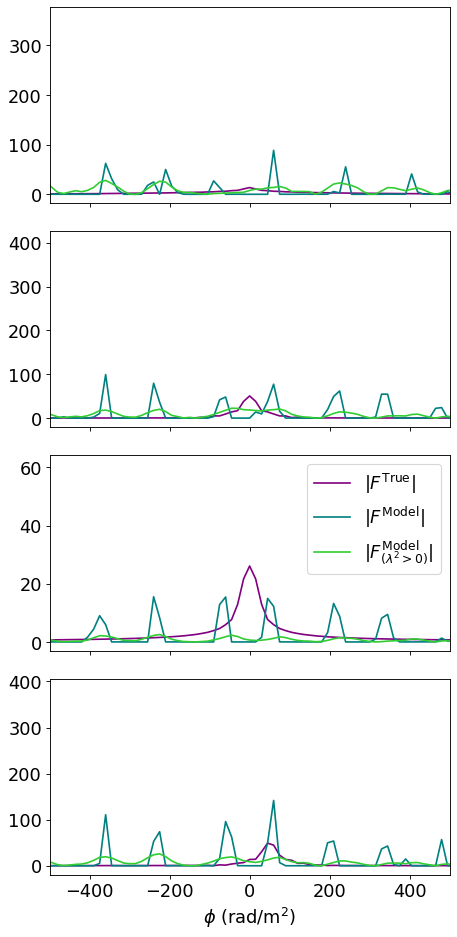

In [14]:
fig1, ax1 = plt.subplots(nrows=4, ncols=1, figsize=(6, 12), dpi=80, sharex=True)
fig2, ax2 = plt.subplots(nrows=4, ncols=1, figsize=(6, 12), dpi=80, sharex=True)
fig3, ax3 = plt.subplots(nrows=4, ncols=1, figsize=(6, 12), dpi=80, sharex=True)
rmse_p = np.zeros((len(rms)))
rmse_n = np.zeros((len(rms)))
for k in range(len(rms)):
    # simulate measurement process
    lambda2_0 = (c/nus[k] * 1e-6)**2
    spectra1 = lambda x: np.real((x/lambda2_0)**(-5/4) * (1 - np.exp(-(x/lambda2_0)**((delta + 4)/2))))
    x_true = models.from_fft_lambda2(lambda x: spectra1(x) * np.exp(1j * x * rms[k]), phi, 0)# + models.from_fft_lambda2(lambda x: spectra2(x) * np.exp(2j * x * -40), phi, 0) * 0.1
    y0 = m_op.dir_op(x_true)
    # add iid noise to measurements
    sigma = 10**(-ISNR/20.) * np.sqrt(np.mean(np.abs(y0)**2)/2.)
    np.random.seed(64)
    y = (y0 + np.random.normal(0, sigma, m_size) + 1j * np.random.normal(0, sigma, m_size)) * weights
    # you can choose the convergence criteria of the algorithm
    options = {'tol': 1e-5, 'iter': 50000, 'update_iter': 1000, 'record_iters': False, 'real': False, 'positivity': False, 'project_positive_lambda2': True} #algorithm properties
    beta= 1e+0 #stepsize that you might have to change 1e-2 to 1e-4 are normally okay, change if result looks bad
    #get solution of algo and run
    options['project_positive_lambda2'] = True
    nu, sol = linear_operators.power_method(m_op, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
    solution_positive, diag_positive = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op, wav, levels, nu, beta, options)
    #get solution of algo and run
    options['project_positive_lambda2'] = False
    solution_negative, diag_negative = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op, wav, levels, nu, beta, options)
    y_positive = m_op.dir_op(solution_positive) 
    y_true = m_op_high_res.dir_op(x_true)
    y_model_positive = m_op_high_res.dir_op(solution_positive)
    y_negative = m_op.dir_op(solution_negative) 
    y_true = m_op_high_res.dir_op(x_true)
    y_model_negative = m_op_high_res.dir_op(solution_negative)
    ax1[k].plot(lambda2_high_res, np.real(y_model_negative))
    ax1[k].plot(lambda2_high_res, np.imag(y_model_negative))
    ax1[k].plot(lambda2_high_res, np.real(y_model_positive))
    ax1[k].plot(lambda2_high_res, np.imag(y_model_positive))
    ax1[k].plot(lambda2_high_res, np.real(y_true), '--')
    ax1[k].plot(lambda2_high_res, np.imag(y_true), '--')
    ax1[-1].set_xlabel(r"$\lambda^2$ (m$^2$)")
    ax1[k].set_ylabel(r"(Jy)")
    ax2[k].plot(freq0/10**9, np.real(y_negative))
    ax2[k].plot(freq0/10**9, np.imag(y_negative))
    ax2[k].plot(freq0/10**9, np.real(y_positive))
    ax2[k].plot(freq0/10**9, np.imag(y_positive))
    ax2[k].errorbar(freq0/10**9, np.real(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
    ax2[k].errorbar(freq0/10**9, np.imag(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
    ax2[-1].set_xlabel(r"$\nu$ (GHz)")
    ax3[k].plot(phi, np.abs(x_true), c="purple")
    ax3[k].plot(phi, np.abs(solution_negative), c="teal")
    ax3[k].plot(phi, np.abs(solution_positive), c="limegreen")
    ax3[-1].set_xlabel(r"$\phi$ (rad/m$^2$)")
    ax3[k].set_xlim([-500, 500])
    rmse_p[k] = np.sqrt(np.mean(np.abs(x_true - solution_positive)**2))/np.sqrt(np.mean(np.abs(x_true)**2))
    rmse_n[k] = np.sqrt(np.mean(np.abs(x_true - solution_negative)**2))/np.sqrt(np.mean(np.abs(x_true)**2))

fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
output_name = str(alpha) + "sync_model"
fig1.savefig(output_name + "_lambda2.pdf")
fig2.savefig(output_name + "_freq.pdf")
fig3.savefig(output_name + "_faraday.pdf")

ax1[2].legend(["$Q^{\\rm Model}$", "$U^{\\rm Model}$", "$Q^{\\rm Model}_{(\lambda^2 > 0)}$", "$U^{\\rm Model}_{(\lambda^2 > 0)}$", "$Q_{\\rm True}$", "$U^{\\rm True}$"], fontsize=16,ncol=2)
ax2[2].legend(["$Q^{\\rm Model}$", "$U^{\\rm Model}$", "$Q^{\\rm Model}_{(\lambda^2 > 0)}$", "$U^{\\rm Model}_{(\lambda^2 > 0)}$", "$Q_{\\rm Measured}$", "$U^{\\rm Measured}$"], fontsize=16,ncol=2)
ax3[2].legend([ "$|F^{\\rm True}|$", "$|F^{\\rm Model}|$", "$|F_{(\lambda^2 > 0)}^{\\rm Model}|$"], fontsize=16)

#fig1.savefig(output_name + "_lambda2_label.pdf")
#fig2.savefig(output_name + "_freq_label.pdf")
#fig3.savefig(output_name + "_faraday_label.pdf")

In [45]:
print(rmse_p)
print(rmse_n)

[0.56779252 0.32826609 0.91969266 0.32014993]
[0.83279686 0.504536   0.91705735 0.45361799]


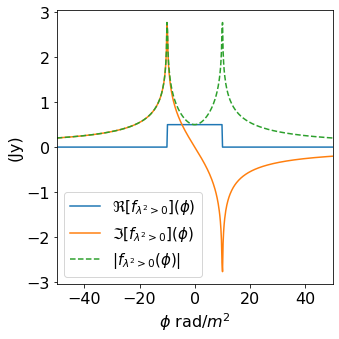

In [20]:
phi_model = np.linspace(-50,50, 512)
P = 1/(2j) * np.log(np.abs(phi_model + 10)/np.abs(phi_model - 10))
P[np.abs(phi_model) < 10] += 1/2
plt.figure(figsize=(5, 5))
plt.plot(phi_model, np.real(P))
plt.plot(phi_model, np.imag(P))
plt.plot(phi_model, np.abs(P),'--')
plt.xlim([-50, 50])
plt.legend(['$\\Re \\left[f_{\lambda^2 > 0} \\right](\\phi)$', '$\\Im \\left[f_{\lambda^2 > 0} \\right](\\phi)$', '$|f_{\lambda^2 > 0} (\\phi)|$'],fontsize=15)
plt.xlabel("$\\phi$ rad/$m^2$")
plt.ylabel("(Jy)")
plt.tight_layout()
#plt.savefig("Ideal_model_box.pdf")

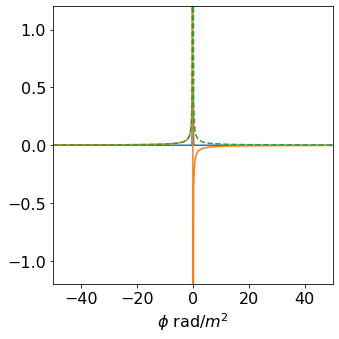

In [18]:
phi_model = np.linspace(-50,50, 512)
P = 1/(2j) * np.log(np.abs(phi_model + 0.1)/np.abs(phi_model - 0.1))
P[np.abs(phi_model) < 0.1] += 1/2
plt.figure(figsize=(5, 5))
plt.plot(phi_model, np.real(P))
plt.plot(phi_model, np.imag(P))
plt.plot(phi_model, np.abs(P),'--')
plt.xlim([-50, 50])
plt.ylim([-1.2, 1.2])
#plt.legend(['$\\Re \\left[F_{\lambda^2 > 0} \\right](\\phi)$', '$\\Im \\left[F_{\lambda^2 > 0} \\right](\\phi)$', '$|F_{\lambda^2 > 0} (\\phi)|$'],fontsize=15)
plt.xlabel("$\\phi$ rad/$m^2$")
#plt.ylabel("Jy")
plt.tight_layout()
#plt.savefig("Ideal_model_delta.pdf")

In [ ]:
trials = 10
ISNRs = [10, 15, 20, 25, 30]
rmse_positive = np.zeros((len(rms), len(ISNRs), trials))
rmse_negative = np.zeros((len(rms), len(ISNRs), trials))

for i in range(len(ISNRs)):
    for k in range(len(rms)):
        for t in range(trials):
            # simulate measurement process
            lambda2_0 = (c/nus[k] * 1e-6)**2
            spectra1 = lambda x: np.real((x/lambda2_0)**(-5/4) * (1 - np.exp(-(x/lambda2_0)**((delta + 4)/2))))
            x_true = models.from_fft_lambda2(lambda x: spectra1(x) * np.exp(1j * x * rms[k]), phi, 0)# + models.from_fft_lambda2(lambda x: spectra2(x) * np.exp(2j * x * -40), phi, 0) * 0.1
            y0 = m_op.dir_op(x_true)
            # add iid noise to measurements
            sigma = 10**(-ISNRs[i]/20.) * np.mean(np.abs(y0))
            y = (y0 + np.random.normal(0, sigma, m_size) + 1j * np.random.normal(0, sigma, m_size)) * weights
            # you can choose the convergence criteria of the algorithm
            options = {'tol': 1e-5, 'iter': 50000, 'update_iter': 1000, 'record_iters': False, 'real': False, 'positivity': False, 'project_positive_lambda2': True} #algorithm properties
            beta= 1e-0 #stepsize that you might have to change 1e-2 to 1e-4 are normally okay, change if result looks bad
            #get solution of algo and run
            options['project_positive_lambda2'] = True
            nu, sol = linear_operators.power_method(m_op, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
            solution_positive, diag_positive = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op, wav, levels, nu, beta, options)
            #get solution of algo and run
            options['project_positive_lambda2'] = False
            solution_negative, diag_negative = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op, wav, levels, nu, beta, options)
            rmse_positive[k, i, t] = np.sqrt(np.mean(np.abs(x_true - solution_positive)**2))/np.sqrt(np.mean(np.abs(x_true)**2))
            rmse_negative[k, i, t] = np.sqrt(np.mean(np.abs(x_true - solution_negative)**2))/np.sqrt(np.mean(np.abs(x_true)**2))

In [ ]:
plt.figure(figsize=(6,6))
plt.errorbar(ISNRs,np.mean(rmse_positive[0, :, :],axis=1),yerr=np.std(rmse_positive[0, :, :],axis=1), c="darkblue", linestyle="--")
plt.errorbar(ISNRs,np.mean(rmse_positive[1, :, :],axis=1),yerr=np.std(rmse_positive[1, :, :],axis=1), c="darkgreen", linestyle="--")
plt.errorbar(ISNRs,np.mean(rmse_positive[2, :, :],axis=1),yerr=np.std(rmse_positive[2, :, :],axis=1), c="darkred", linestyle="--")
plt.errorbar(ISNRs,np.mean(rmse_positive[3, :, :],axis=1),yerr=np.std(rmse_positive[3, :, :],axis=1), c="darkorange", linestyle="--")

plt.errorbar(ISNRs,np.mean(rmse_negative[0, :, :],axis=1),yerr=np.std(rmse_negative[0, :, :],axis=1), c="darkblue")
plt.errorbar(ISNRs,np.mean(rmse_negative[1, :, :],axis=1),yerr=np.std(rmse_negative[1, :, :],axis=1), c="darkgreen")
plt.errorbar(ISNRs,np.mean(rmse_negative[2, :, :],axis=1),yerr=np.std(rmse_negative[2, :, :],axis=1), c="darkred")
plt.errorbar(ISNRs,np.mean(rmse_negative[3, :, :],axis=1),yerr=np.std(rmse_negative[3, :, :],axis=1), c="darkorange")

plt.ylim([0, 6.7])
plt.ylabel("NRMSE")
plt.xlabel("ISNR")
plt.legend(["${\\rm Model_1}\quad {(\lambda^2 > 0)}$", "${\\rm Model_2}\quad {(\lambda^2 > 0)}$", "${\\rm Model_3}\quad {(\lambda^2 > 0)}$", "${\\rm Model_4}\quad {(\lambda^2 > 0)}$","${\\rm Model}_1$", "${\\rm Model}_2$", "${\\rm Model}_3$", "${\\rm Model}_4$"], fontsize=16,ncol=2)
plt.tight_layout()
#plt.savefig("error_plot.pdf")